##  使用dataset测试准确率

In [1]:
import tensorflow as tf
import os
import tensorflow.contrib.slim as slim
from create_record_files import get_example_nums
import PARAMS as Param
from models import dense_net_b3_k16 as net
import dataset_factory.dataset_factory as datasets
from tensorflow.python.ops import control_flow_ops
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from utils import plot_confusion_matrix
%matplotlib inline


In [2]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_DEPTH = 3
NUM_CLASS = 3
BATCH_SIZE = 32

In [3]:
# list1 = [1,2,4]
# list2 = [4,5]
# list1 = list1 + list2
# print(list1)

In [4]:
models_path = 'shell_model/model_epoch265_0.8455.ckpt'  #查看checkPoint的名称即可

In [5]:
validation_index = 5
labels_filename = "dataset/label.txt"
val_dir = "dataset/record_file/iwatch_224_record_v{0}/val".format(validation_index)
val_num = get_example_nums(val_dir)
print("validation num = {0}".format(val_num))

['val-00-of-00']
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
validation num = 110


定义数据集


In [6]:
test_dataset = datasets.get_dataset('iwatch', val_dir,'test', batch_size=BATCH_SIZE,label_num=3)
test_iterator = test_dataset.make_initializable_iterator()
test_images, test_labels = test_iterator.get_next()
labels = np.loadtxt(labels_filename, str, delimiter='\t')

['dataset/record_file/iwatch_224_record_v5/val\\val-00-of-00']
Instructions for updating:
Colocations handled automatically by placer.


define model

In [7]:
# print_tensors_in_checkpoint_file(models_path, None, False, True)
with tf.name_scope("inputs"):
    is_training = tf.placeholder(tf.bool)
    images = tf.placeholder(
        dtype=tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH], name='inputs')
    labels = tf.placeholder(dtype=tf.int32, shape=[None, NUM_CLASS], name='label')

with tf.name_scope('nets'):
    logits, endPoints = net.inference(inputs=images, num_classes=NUM_CLASS,
                                      weights_reg = 0.0001,
                                      is_training=False, dropout_keep_prob = 1.0)
# 将输出结果进行softmax分布,再求最大概率所属类别
with tf.name_scope('Output'):
    score = tf.nn.softmax(logits,name='predict')
    class_id = tf.argmax(score, 1)
    correct_prediction = tf.equal(class_id, tf.argmax(labels, 1))
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [8]:
def test_dataSet():
    init_op = [tf.global_variables_initializer(), tf.local_variables_initializer()]
    pre_labels = []
    ground_labels = []
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, models_path)
        sess.run(test_iterator.initializer)
        num_correct, num_samples = 0, 0
        while True:
            try:
                test_batch_images, test_batch_labels \
                    = sess.run([test_images, test_labels])
                ground_labels = ground_labels + list(np.argmax(test_batch_labels, 1))
                score_val, correct_pred,class_index \
                    = sess.run([ score,correct_prediction,class_id],
                               feed_dict={is_training: False,
                                          images: test_batch_images,
                                           labels: test_batch_labels})
                pre_labels = pre_labels + list(class_index)
                num_correct += correct_pred.sum()
                num_samples += correct_pred.shape[0]
            except tf.errors.OutOfRangeError:
                break
        acc = float(num_correct) / num_samples
        return acc, ground_labels, pre_labels

In [9]:
acc, g,p = test_dataSet()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from shell_model/model_epoch265_0.8455.ckpt


In [10]:
labels = np.loadtxt('dataset/label.txt', dtype=str)
print(labels)

['dust' 'NG' 'OK']


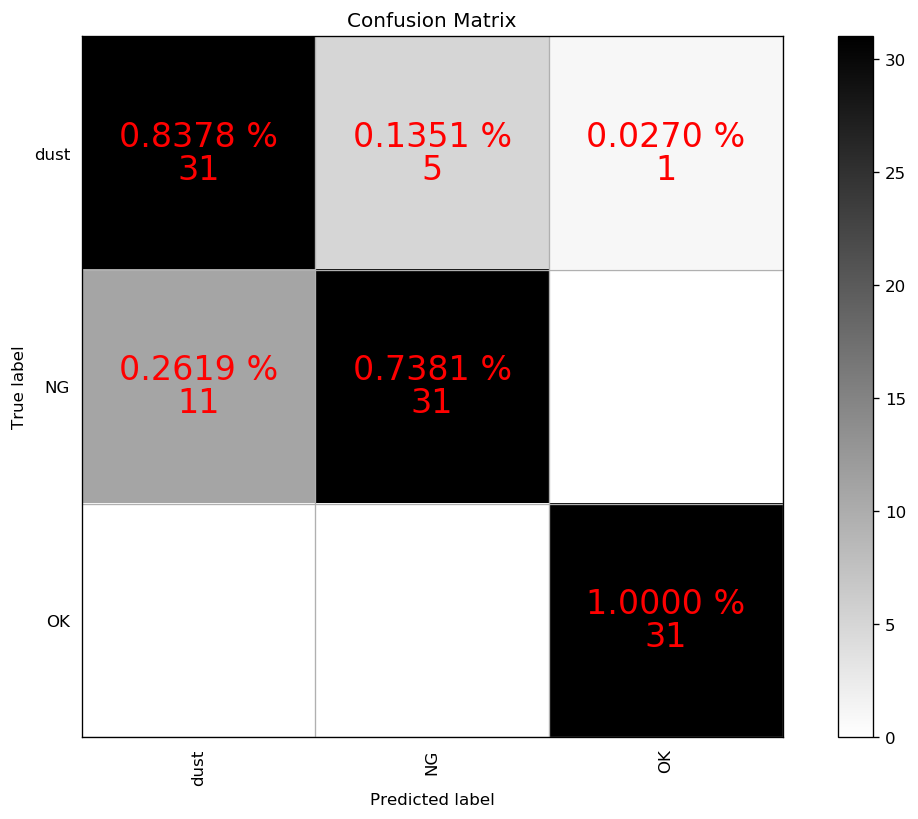

In [11]:
plot_confusion_matrix(labels, g, p)